In [0]:
# intall the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
download = drive.CreateFile({'id':'1RkHuvc_TAtrMXMrWsx5AX1DdGL6352aI'})
download.GetContentFile('dataset2.zip')

!unzip dataset2.zip

Archive:  dataset2.zip
   creating: dataset2/
   creating: dataset2/test/
   creating: dataset2/test/notApples/
  inflating: dataset2/test/notApples/hqdefault.jpg  
  inflating: dataset2/test/notApples/ft_train_and_val_acc_smooth_graph.png  
  inflating: dataset2/test/notApples/ft_train_and_val_loss_smooth_graph.png  
  inflating: dataset2/test/notApples/ft_training_and_val_acc_graph.png  
  inflating: dataset2/test/notApples/ft_training_and_val_loss_graph.png  
  inflating: dataset2/test/notApples/0_100pi.jpg  
  inflating: dataset2/test/notApples/1_100pi.jpg  
  inflating: dataset2/test/notApples/2_100pi.jpg  
  inflating: dataset2/test/notApples/4_100pi.jpg  
  inflating: dataset2/test/notApples/5_100pi.jpg  
  inflating: dataset2/test/notApples/6_100pi.jpg  
  inflating: dataset2/test/notApples/22_100t.jpg  
  inflating: dataset2/test/notApples/23_100t.jpg  
  inflating: dataset2/test/notApples/29_100t.jpg  
  inflating: dataset2/test/notApples/30_100t.jpg  
  inflating: dataset2/t

In [3]:
# Run it to obtain reproducible results across machines (from keras.io)

from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [7]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import ResNet50
from keras import models
from keras import layers
from keras import optimizers
#from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import os
import numpy as np

# get train directory
train_dir = os.path.join('dataset2', 'train')
validation_dir = os.path.join('dataset2', 'validation')
test_dir = os.path.join('dataset2', 'test')

# initialize the convolutional base
inception_base = ResNet50(weights='imagenet',
                 include_top=False)

# Construct the model
"""
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
"""
#print(model.summary())
x = inception_base.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = layers.Dense(2, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = models.Model(inputs=inception_base.input, outputs=predictions)

# note old learning rate = 2e-5
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
# create a data augmentation generator for the train and text dataset

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=15,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=15,
    class_mode='categorical')

# note old epochs = 30
history = inception_transfer.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=25,
    shuffle=True,
    verbose=1,
    validation_data=validation_generator, validation_steps=25)

inception_transfer.save('apple_grading_model9.h5')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 2155 images belonging to 2 classes.
Found 1132 images belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 30s 1s/step - loss: 0.3486 - acc: 0.8720 - val_loss: 0.3381 - val_acc: 0.8907
Epoch 2/100
25/25 [==============================] - 14s 576ms/step - loss: 0.1126 - acc: 0.9680 - val_loss: 0.3100 - val_acc: 0.8800
Epoch 3/100
25/25 [==============================] - 14s 573ms/step - loss: 0.1114 - acc: 0.9680 - val_loss: 0.2513 - val_acc: 0.9013
Epoch 4/100
25/25 [==============================] - 15s 597ms/step - loss: 0.1479 - acc: 0.9440 - val_loss: 0.2401 - val_acc: 0.8828
Epoch 5/100
25/25 [==============================] - 15s 589ms/step - loss: 0.0856 - acc: 0.9707 - val_loss: 0.2211 - val_acc: 0.8933
Epoch 6/100
25/25 [==============================] - 16s 624ms/step - loss: 0.0566 - acc: 0.9840 - val_loss: 0.1715 - val_acc: 0.9147
Epoch 7/100
25/25 [==============================] - 15s 589ms/step - loss: 0.0789 - acc: 0.9707 - val_loss: 0.1710

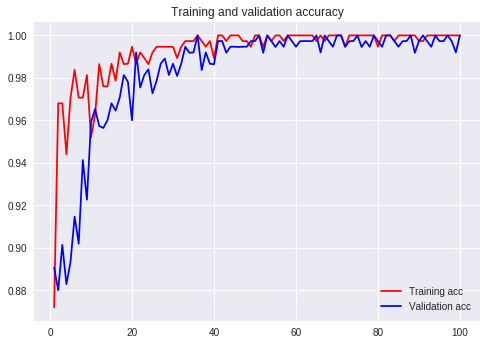

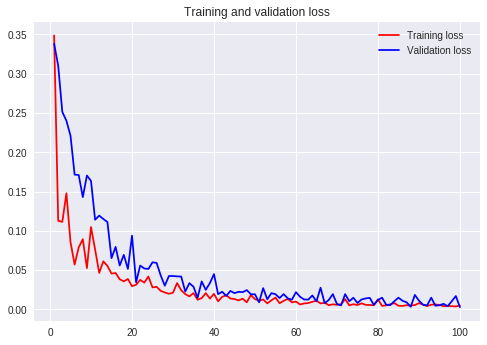

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

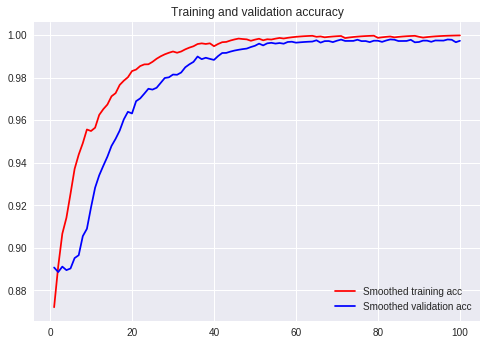

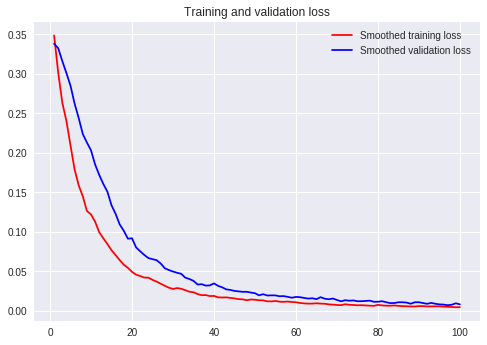

In [9]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
  
plt.plot(epochs,
    smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
    smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
    smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
    smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=15,
    class_mode='categorical')

test_loss, test_acc = inception_transfer.evaluate_generator(test_generator, steps=25)
print('test acc:', test_acc)

Found 1061 images belonging to 2 classes.
test acc: 1.0


In [0]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

model = VGG16(weights='imagenet',
             include_top=False)

  
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  x += 0.5
  x = np.clip(x, 0, 1)
  
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

def generate_pattern(layer_name, filter_index, size=100):
  layer_output=model.get_layer(layer_name).output
  loss=K.mean(layer_output[:,:,:, filter_index])

  grads=K.gradients(loss, model.input)[0]

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

  iterate = K.function([model.input], [loss, grads])

  input_image_data = np.random.random((1, size, size, 3)) * 20 + 128

  step = 1
  for i in range(40):
    loss_value, grads_value=iterate([input_image_data])
    input_image_data += grads_value * step
    
  img=input_image_data[0]
  return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

In [0]:
layer_name = 'block1_conv1'
size = 64
margin=5

results=np.zeros((8* size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j*8), size = size)
    
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)

In [13]:
from keras.models import load_model
from keras import optimizers
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np

model = load_model('apple_grading_model9.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

imagePath='dataset2/test/Apples/27b.jpg'
test_image = image.load_img(imagePath, target_size=(224,224)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = preprocess_input(test_image)
test_image /= 255.
#predict the result
result = model.predict(test_image)
print(result)

y_classes = result.argmax(axis=-1)
print(y_classes)

#print(decode_predictions(result))

[[9.9956709e-01 4.3294873e-04]]
[0]


In [14]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'parents': [{u'id' : '109rI9N702jHgTQHESsCXAr6EYxY62N0W'}]})
uploaded.SetContentFile('apple_checker_model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1CQlBBXlNEk4aeftnVnMxgkJBjuiHxVFn
